<a href="https://colab.research.google.com/github/Beckmari/PhylogeneticAnalysis_Colab/blob/main/PhyloAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title install python dependencies
!pip install biopython
#Importing biopython and os for safety
import os
import sys
import Bio
#Installing MAFFT using apt-get in quiet mode
!apt-get install -qq -y mafft
#Checking that MAFFT was succesfully installed
!mafft --help
#Install conda using the new conda-colab library
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()

!conda install -c bioconda iqtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.1 MB/s eta 0:00:00
Extracting templates from packages: 100%
Selecting previously unselected package fonts-lato.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../00-fonts-lato_2.0-2.1_all.deb ...
Unpacking fonts-lato (2.0-2.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package libclone-perl.
Preparing to unpack .../02-libclone-perl_0.45-1build3_amd64.deb ...
Unpacking libclone-perl (0.45-1build3) ...
Selecting previously unselected package libdata-dump-perl.
Preparing to unpack .../03-libdata-dump-perl_1.25-1_all.deb ...
Unpacking libdata-dump-perl (1.25-1) ...
Selecting previously unselected package libencode-locale-perl.
Preparing to unpack .../04-libencode-locale-perl_1.05-1.1_all.deb ...
Unpacking libencode-locale-perl (1.05-1.1) ...
Selecting previously unsel

In [1]:
# @title Enter your eMail adress for Entrez use (necassary)
eMail = 'marius.beck@uni-siegen.de' #@param {type:"string"}

In [3]:
# @title Mount Google drive to store data to defined storage folder
Folder = 'PA13A3' #@param {type:"string"}
import os
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/
directory = os.getcwd()
path = directory + '/' + Folder
if os.path.isdir(Folder):
  print("IMPORTANT: Directory already exists and we will use it. Otherwise choose a new file-name that doesn't exit and run this cell again!")
else:
  os.mkdir(path)
os.chdir(path)
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


'/content/gdrive/MyDrive/PA13A3'

In [ ]:
# @title Enter protein sequence for blast
Query_Sequence = "MAKIQARFFLFLVFFTVIRNNESAEMVDAHLGKKYKLASSENFDEFMKALGVGLVTRKMG NAVSPVVELTKNDDEYTLSSSSTFKNVVLKFKPGVEFDQETPDGRKVKATITVDGNTLHE VQKDPSSGKETVIDRTFTDDEVKMVMSVDNITATRIYKIQA" # @param {type:"string"}
from Bio.Seq import Seq
aaseq = Seq(Query_Sequence)

In [ ]:
# @title Import taxIDs manually curated
#upload file of organisms
from google.colab import files
uploaded = files.upload()
key, value = list(uploaded.items())[0]
taxdir = os.getcwd()
taxfile = taxdir + '/' + key

import openpyxl

wb = openpyxl.load_workbook(taxfile)
ws = wb.active
my_list = list()

for value in ws.iter_rows(
    min_row=1, max_row=38, min_col=1, max_col=1,
    values_only=True):
    value = str(value)
    my_list.append(value)

my_list = [species.replace('(', '') for species in my_list]
my_list = [species.replace(')', '') for species in my_list]
my_list = [species.replace('\'', '') for species in my_list]
my_list = [species.replace(',', '') for species in my_list]
taxID_list = my_list[:]

In [ ]:
# @title Perfom NCBIWWW Blast and parse result by NCBIXML
import csv
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import SeqIO, Entrez
Entrez.email = eMail
PIDcut=0.35
PCOcut = 0.75
blast_handle = []

for row in taxID_list[:]:
    tid = str(row)
    tid = tid + ' [ORGN]'
    print()
    print(tid)
    print()
    result_handle = NCBIWWW.qblast("blastp", "nr", aaseq, entrez_query = tid, word_size=5, expect=0.05, hitlist_size=100, gapcosts="11 1", matrix_name='BLOSUM62', filter='F', genetic_code=1)
    blast_handle = NCBIXML.read(result_handle)
    for alignment in blast_handle.alignments:
        k=0
        for hsp in alignment.hsps:
              k = k + (hsp.query_end - hsp.query_start + 1)/len(aaseq)
        for hsp in alignment.hsps:
            if(hsp.identities/hsp.align_length) >= PIDcut:
              if(k) >= PCOcut: #not matching with query coverage
                print("Accession code:", alignment.hit_id)
                print("Sequence length:", alignment.length)
                print("Alignment length:", hsp.align_length)
                print("E-value:", hsp.expect)
                print("Sequence Identity [%]:", "{:.2f}".format(100*hsp.identities/hsp.align_length))
                print("Sequence Coverage [%]:", "{:.2f}".format(100*((hsp.query_end - hsp.query_start + 1)/len(aaseq))))
                print("Query Coverage [%]:", "{:.2f}".format(100*(k)))
                print()
                print("query:", hsp.query[0:60] + "...")
                print("      ", hsp.match[0:60] + "...")
                print("sbjct:", hsp.sbjct[0:60] + "...")
                print()
    with open("sequences.fasta", "a") as allhits_out:
      for alignment in blast_handle.alignments[:20]:
        for hsp in alignment.hsps:
          if(hsp.identities/len(hsp.match)) >= PIDcut:
            if(sum(c.isalpha() for c in hsp.query)/len(aaseq)) >= PCOcut:
              print("Fetching protein sequence:", alignment.hit_id)
              fetch = Entrez.efetch(db="protein", id=alignment.hit_id, rettype="fasta")
              allhits_seqs = SeqIO.read(fetch, format="fasta")
              SeqIO.write(allhits_seqs, allhits_out, "fasta")
              fetch.close()

    allhits_out.close()
    result_handle.close()


In [4]:
# @title Create MSA
from Bio.Align.Applications import MafftCommandline
mafft_cline=MafftCommandline(input="sequences.fasta")
print(mafft_cline)
stdout, stderr = mafft_cline()
with open("aligned.fasta", "w") as handle:
  handle.write(stdout)
from Bio import AlignIO
align = AlignIO.read("aligned.fasta", "fasta")

/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


mafft sequences.fasta


In [5]:
import sys
from Bio import AlignIO, SeqIO
aln = AlignIO.read("aligned.fasta", "fasta")

for fcol in range(aln.get_alignment_length()):
  if not "-" in aln[:, fcol]:
    position1 = fcol
    print("First full column is {}".format(fcol))
    break
for lcol in reversed(range(aln.get_alignment_length())):
  if not "-" in aln[:, lcol]:
    position2 = lcol+1
    print("Last full column is {}".format(lcol))
    break

print("New alignment:")
print(aln[:, position1:position2])

with open("aligned_trimmed.fasta", "w") as handle:
  count = (SeqIO.write(aln[:, position1:position2], handle, "fasta"))

trim = AlignIO.read("aligned_trimmed.fasta", "fasta")

First full column is 690
Last full column is 1675
New alignment:
Alignment with 136 rows and 986 columns
ALRQTRKQSEALHDLVESSKCHNVRVLR--R-----------NL...YMA XP_008191593.1
ALRQTRKQSEALHDLVESSKCHNVRVLR--R-----------NL...YMA XP_015834823.1
ALRQTRKQSEALHDLVESSKCHNVRVLR--R-----------NL...YMA XP_064215196.1
TVRQTRKNQRNLKSTVHSSD--VCTVLR--KIPKNCDGSGDVSY...YMA XP_008195050.1
TVRQTRKNQRNLKSTVHSSD--VCTVLR--KIPKNCDGSGDVSY...YMA XP_972127.1
TVRQTRKNQRNLKSTVHSSD--VCTVLR--KIPKNCDGSGDVSY...YMA XP_015836587.1
SIIQTRKSQENLKGTVHTAD--KIMVSR--S-----------DG...LML XP_008194528.1
SILQTQKNQKALYSTVKNSD--TAMVVR--D-----------NC...YMA EAT39291.1
SILQTQKNQKALYSTVKNSD--TAMVVR--D-----------NC...YMA XP_001659588.2
ALRQTRKQSEALHDLVESSKCHNVRVLR--R-----------NL...YMA XP_008191593.1
ALRQTRKQSEALHDLVESSKCHNVRVLR--R-----------NL...YMA XP_015834823.1
ALRQTRKQSEALHDLVESSKCHNVRVLR--R-----------NL...YMA XP_064215196.1
TVRQTRKNQRNLKSTVHSSD--VCTVLR--KIPKNCDGSGDVSY...YMA XP_008195050.1
TVRQTRKNQRNLKSTVHSSD--VCTVLR--KIPKNCDGSGDVSY

In [7]:
#Sequence cleaner script
#Modified from https://peterjc.github.io/wiki/Sequence_Cleaner
from Bio import SeqIO

def sequence_cleaner(fasta_file, min_length=0):
  # Create our hash table to add the sequences
  sequences = {}
  # Using the Biopython fasta parse we can read our fasta input
  for seq_record in SeqIO.parse(fasta_file, "fasta"):
    # Take the current sequence
    sequence = str(seq_record.seq).upper()
    # Check if the current sequence is according to the user parameters
    if (len(sequence) >= min_length):
      # If the sequence passed in the test "is it clean?" and it isn't in the
      # hash table, the sequence and its id are going to be in the hash
        if sequence not in sequences:
          sequences[sequence] = seq_record.id
      # If it is already in the hash table, we're just gonna concatenate the ID
      # of the current sequence to another one that is already in the hash table
        else:
          sequences[sequence] += "_" + seq_record.id

  # Write the clean sequences
  # Create a file in the same directory where you ran this script
  with open("clear_" + fasta_file, "w+") as output_file:
  # Just read the hash table and write on the file as a fasta format
    for sequence in sequences:
      output_file.write(">" + sequences[sequence] + "\n" + sequence + "\n")
  print("CLEAN!!!\nPlease check clear_" + fasta_file)

In [12]:
sequence_cleaner('clear_aligned_trimmed.fasta', 0)

CLEAN!!!
Please check clear_clear_aligned_trimmed.fasta


In [13]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
aln = AlignIO.read(open('clear_aligned_trimmed.fasta'), 'fasta')
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)
print(dm)

XP_008191593.1_XP_015834823.1_XP_064215196.1_XP_008191593.1_XP_015834823.1_XP_064215196.1   0.000000
XP_008195050.1_XP_972127.1_XP_015836587.1_XP_008195050.1_XP_972127.1_XP_015836587.1 0.399594    0.000000
XP_008194528.1_XP_008194528.1   0.375254    0.336714    0.000000
EAT39291.1_XP_001659588.2_EAT39291.1_XP_001659588.2 0.433063    0.351927    0.370183    0.000000
XP_030023447.1  0.316430    0.414807    0.396552    0.453347    0.000000
XP_030020638.2_XP_030020636.2   0.423935    0.415822    0.354970    0.427992    0.448276    0.000000
KAG6445459.1_KAG6445457.1_KAG6445460.1  0.423935    0.414807    0.354970    0.429006    0.447262    0.005071    0.000000
XP_031788026.1  0.393509    0.369168    0.307302    0.402637    0.418864    0.368154    0.367140    0.000000
XP_008204138.1_XP_032458038.1   0.398580    0.367140    0.302231    0.389452    0.423935    0.365112    0.364097    0.217039    0.000000
XP_002425353.1  0.396552    0.324544    0.321501    0.348884    0.418864    0.385396    0.3

In [14]:
!iqtree -s clear_aligned_trimmed.fasta -m MFP -B 1000 -nt AUTO --prefix PA13A3

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
IQ-TREE multicore version 2.1.4-beta COVID-edition for Linux 64-bit built Jun 24 2021
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    ca1a130d1d42 (AVX2, FMA3, 12 GB RAM)
Command: iqtree -s clear_aligned_trimmed.fasta -m MFP -B 1000 -nt AUTO --prefix PA13A3
Seed:    811205 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Wed Oct 16 19:28:57 2024
Kernel:  AVX+FMA - auto-detect threads (2 CPU cores detected)

Reading alignment file clear_aligned_trimmed.fasta ... Fasta format detected
Alignment most likely contains protein sequences
Alignment has 60 sequences with 986 columns, 862 distinct patterns
653 parsimony-informative, 91 singleton sites, 242 constant sites
                                                                                                                           

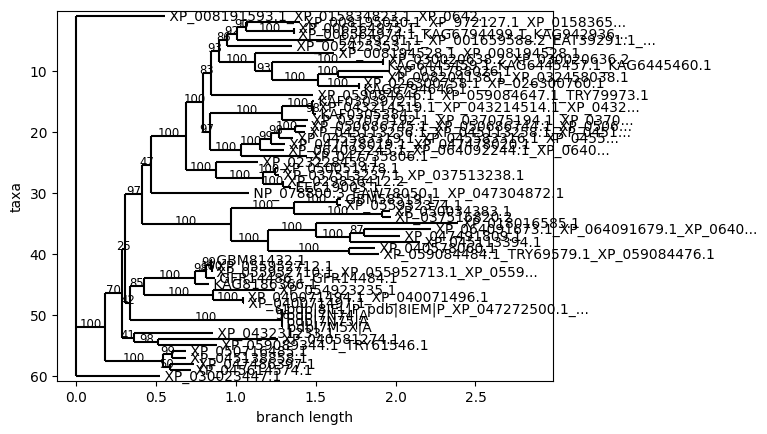

In [15]:
from Bio import Phylo
tree = Phylo.read("PA13A3.contree", "newick")
Phylo.draw(tree)

In [16]:
#@title Protein MSA Viewer in Google Colab
#The following code is modified from the wonderful viewer developed by Damien Farrell
#https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner

#Importing all modules first
import os, io, random
import string
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

#Setting up the amino color code according to Zappo color scheme
def get_colors(seqs):
    #make colors for bases in sequence
    text = [i for s in list(seqs) for i in s]
    #Use Zappo color scheme
    clrs =  {'K':'red',
             'R':'red',
             'H':'red',
             'D':'green',
             'E':'green',
             'Q':'blue',
             'N':'blue',
             'S':'blue',
             'T':'blue',
             'A':'blue',
             'I':'blue',
             'L':'blue',
             'M':'blue',
             'V':'blue',
             'F':'orange',
             'Y':'orange',
             'W':'orange',
             'C':'blue',
             'P':'yellow',
             'G':'orange',
             '-':'white',
             'X':'white'}
    colors = [clrs[i] for i in text]
    return colors

#Setting up the MSA viewer
def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs = [rec.seq for rec in (aln)]
    ids = [rec.id for rec in aln]
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)
    N = len(seqs[0])
    S = len(seqs)
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, width= plot_width, height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, width=plot_width, height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p

#Loading the viewer by indicating the MSA file and format to read
#@markdown Name of the MSA file (including the filetype)
MSAfile = 'clear_aligned_trimmed.fasta' #@param {type:"string"}
MSAformat = 'fasta' #@param {type:"string"}
aln = AlignIO.read(MSAfile,MSAformat)
p = view_alignment(aln, plot_width=900)
pn.pane.Bokeh(p)

<ipython-input-16-351deeec971d>:16: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  pn.extension()


Bokeh(GridPlot)